In [1]:
import time
import matplotlib
import sys
import scipy
import numpy as np
import easygui
import matplotlib.pyplot as plt
import mne
from IPython.display import clear_output
import re
import pickle
import dynarray
import random

import logging  # set log level
logging.basicConfig(level=logging.WARNING)

sys.path.append("../../mushu")  # driver for the amps
sys.path.append("../../mushu/libmushu")
import libmushu

sys.path.append("../../callpyff")   # talk to the stimuli
from callpyff import bcinetwork, bcixml 

sys.path.append("../../nftools")  # handy stuff needed for NF
from nftools.loopcontrol import LoopState
from nftools.analysis import convert_alld_allm_to_mne
from nftools.analysis import select_part_from_mne_dataset
from nftools.analysis import plot_compare_two_spectra
from nftools import camera

sys.path.append("../../wyrm")  # real-time data analysis
from wyrm.types import RingBuffer
from wyrm.types import BlockBuffer
from wyrm import io
from wyrm import processing as proc

from scipy import signal


sys.path.append('/home/nfcontrol/nf/nf-rtime/callpyff/')

In [2]:
# real-time data filtering

fs=5000.
f_low = 12.0
f_high = 15.0
butter_ord = 2
lenchannels = 64

b, a = signal.butter(butter_ord, [f_low / fs, f_high / fs], btype='band')
#b, a = signal.butter(butter_ord, 2*f_low/fs, btype='high', analog=False)  # a high-pass filter
zi = proc.lfilter_zi(b, a, lenchannels)


In [3]:
print(b)
print(a)
print(zi)

[ 8.87081774e-07  0.00000000e+00 -1.77416355e-06  0.00000000e+00
  8.87081774e-07]
[ 1.         -3.99719225  5.9917225  -3.99186807  0.99733782]
[[-8.87081972e-07 -8.87081972e-07 -8.87081972e-07 -8.87081972e-07
  -8.87081972e-07 -8.87081972e-07 -8.87081972e-07 -8.87081972e-07
  -8.87081972e-07 -8.87081972e-07 -8.87081972e-07 -8.87081972e-07
  -8.87081972e-07 -8.87081972e-07 -8.87081972e-07 -8.87081972e-07
  -8.87081972e-07 -8.87081972e-07 -8.87081972e-07 -8.87081972e-07
  -8.87081972e-07 -8.87081972e-07 -8.87081972e-07 -8.87081972e-07
  -8.87081972e-07 -8.87081972e-07 -8.87081972e-07 -8.87081972e-07
  -8.87081972e-07 -8.87081972e-07 -8.87081972e-07 -8.87081972e-07
  -8.87081972e-07 -8.87081972e-07 -8.87081972e-07 -8.87081972e-07
  -8.87081972e-07 -8.87081972e-07 -8.87081972e-07 -8.87081972e-07
  -8.87081972e-07 -8.87081972e-07 -8.87081972e-07 -8.87081972e-07
  -8.87081972e-07 -8.87081972e-07 -8.87081972e-07 -8.87081972e-07
  -8.87081972e-07 -8.87081972e-07 -8.87081972e-07 -8.87081972e-

In [4]:
# load from disk:

with open('c-allm-and-alld.pkl','rb') as f:
    t=pickle.load(f)
for key in t.keys():
    locals()[key] = t[key]

In [5]:
ch_names = ['ch_%d' % i for i in range(64)]

In [6]:
m1=alld[0:20000,:]
m2=alld[20000:40000,:]

In [7]:
cnt1 = io.convert_mushu_data(m1, [], 5000, ch_names)
cnt2 = io.convert_mushu_data(m2, [], 5000, ch_names)

AssertionError: 

In [ ]:
with open('zeroelement.pkl','rb') as f:
    zeroelement = pickle.load(f)

In [9]:
# let's make a '0' data element?


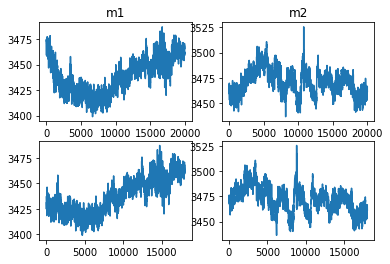

In [10]:
plt.figure()
plt.subplot(221)
plt.plot(cnt1.data[:,10])
plt.title('m1')
plt.subplot(223)
plt.plot(cnt1.data[2000:,10])
plt.subplot(222)
plt.plot(cnt2.data[:,10])
plt.title('m2')
plt.subplot(224)
plt.plot(cnt2.data[2000:,10])


In [68]:
# filter them it with wyrm -- continuous

f_1 = proc.lfilter(cnt1, b, a)
f_0 = proc.lfilter(zeroelement, b, a)
f_2 = proc.lfilter(cnt2, b, a)

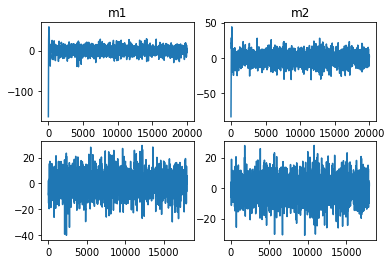

In [69]:
plt.figure()
plt.subplot(221)
plt.plot(f_1.data[:,10])
plt.title('m1')
plt.subplot(223)
plt.plot(f_1.data[2000:,10])
plt.subplot(222)
plt.plot(f_2.data[:,10])
plt.title('m2')
plt.subplot(224)
plt.plot(f_2.data[2000:,10])

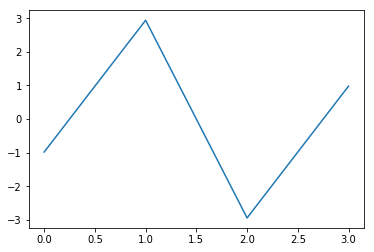

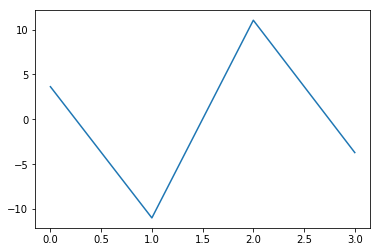

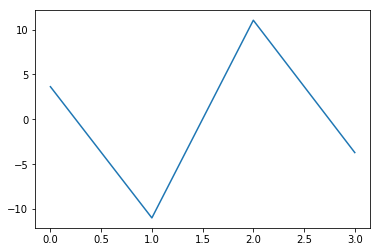

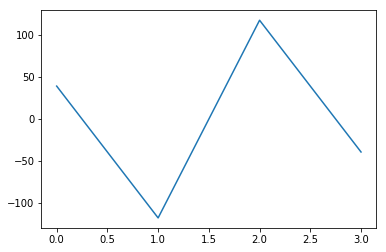

In [70]:
# NOW -- filter it with remembering the state:

zi1=zi
f2_1, zi = proc.lfilter(cnt1, b, a, zi=zi)
zi2=zi
f2_0, zi = proc.lfilter(zeroelement, b, a, zi=zi)
zi3=zi
f2_2, zi = proc.lfilter(cnt2, b, a, zi=zi)
zi4=zi

plt.figure()
plt.plot(zi1[:,1])
plt.figure()
plt.plot(zi2[:,1])
plt.figure()
plt.plot(zi3[:,1])
plt.figure()
plt.plot(zi4[:,1])

# plt.plot(zi3[:,1])

#plt.imshow(zi3)
#plt.colorbar()
#print(zi2)
#print(zi3)

In [14]:
zi4

array([[ 2.33135065e+04,  2.25458253e+04,  1.93640207e+04,
         6.93774477e+03,  5.30970994e+03,  1.07731412e+03,
         9.57044820e+02, -1.15090056e+03,  1.31598680e+03,
         3.45809823e+03, -3.43281267e+03,  1.48420412e+03,
         1.82363994e+04,  3.48057325e+02,  4.66122454e+03,
         5.61857939e+02, -1.25354671e+03, -2.58560453e+02,
         1.40345580e+04,  1.91378529e+03,  1.20527330e+04,
        -3.00038433e+03, -1.72221942e+03,  3.79219141e+03,
        -9.08323812e+02, -4.86179411e+02,  1.42123795e+03,
         5.77144263e+01,  3.90188335e+03,  4.56830493e+03,
         2.06783497e+03,  2.41390411e+04,  7.32245163e+03,
         5.14579362e+03,  2.18337663e+03,  4.25264232e+03,
         5.48345664e+03,  1.02674313e+03,  3.36916167e+03,
         3.16384127e+02,  4.96353470e+03,  4.66451150e+03,
         5.50815222e+03,  2.64303017e+03,  2.81900508e+03,
         4.40261238e+03,  1.39297082e+03,  2.03012801e+03,
         1.13686733e+03,  4.21750322e+03,  3.75794072e+0

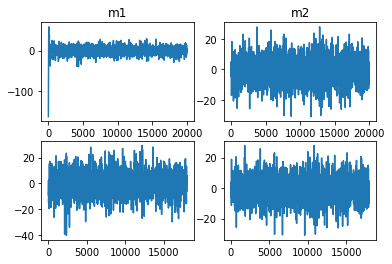

In [71]:
plt.figure()
plt.subplot(221)
plt.plot(f2_1.data[:,10])
plt.title('m1')
plt.subplot(223)
plt.plot(f2_1.data[2000:,10])
plt.subplot(222)
plt.plot(f2_2.data[:,10])
plt.title('m2')
plt.subplot(224)
plt.plot(f2_2.data[2000:,10])

# result:
-- it worked!!
The second picture does NOT anymore show the step-response shown in the earlier figure. Let's cross-check this wit hfilter applied to continuous data

In [19]:
w

array([0.        , 0.00613592, 0.01227185, 0.01840777, 0.02454369,
       0.03067962, 0.03681554, 0.04295146, 0.04908739, 0.05522331,
       0.06135923, 0.06749515, 0.07363108, 0.079767  , 0.08590292,
       0.09203885, 0.09817477, 0.10431069, 0.11044662, 0.11658254,
       0.12271846, 0.12885439, 0.13499031, 0.14112623, 0.14726216,
       0.15339808, 0.159534  , 0.16566993, 0.17180585, 0.17794177,
       0.18407769, 0.19021362, 0.19634954, 0.20248546, 0.20862139,
       0.21475731, 0.22089323, 0.22702916, 0.23316508, 0.239301  ,
       0.24543693, 0.25157285, 0.25770877, 0.2638447 , 0.26998062,
       0.27611654, 0.28225246, 0.28838839, 0.29452431, 0.30066023,
       0.30679616, 0.31293208, 0.319068  , 0.32520393, 0.33133985,
       0.33747577, 0.3436117 , 0.34974762, 0.35588354, 0.36201947,
       0.36815539, 0.37429131, 0.38042724, 0.38656316, 0.39269908,
       0.398835  , 0.40497093, 0.41110685, 0.41724277, 0.4233787 ,
       0.42951462, 0.43565054, 0.44178647, 0.44792239, 0.45405

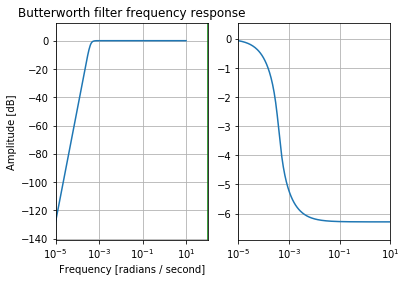

/home/johan/.conda/envs/rt/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


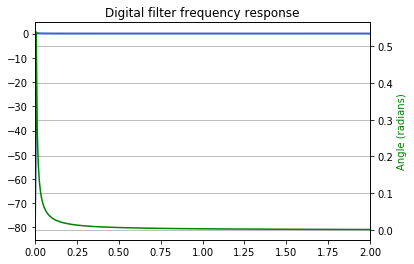

In [25]:
f_low = 1.0
fs = 5000
b, a = signal.butter(4, 2*f_low/fs, btype='high', analog=True)  # a high-pass filter


w, h = signal.freqs(b, a)


plt.figure()
plt.subplot(121)
plt.plot(w, 20 * np.log10(abs(h)))
plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.subplot(122)
plt.plot(w, np.unwrap(np.angle(h)))
plt.xscale('log')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')


plt.show()


b, a = signal.butter(4, 2*f_low/fs, btype='high', analog=False)  # a high-pass filter

w, h = signal.freqz(b, a)

fig = plt.figure()
plt.title('Digital filter frequency response')
ax1 = fig.add_subplot(111)


plt.plot(w, 20 * np.log10(abs(h)), 'b')
#plt.subplot(122)
plt.plot(w, np.unwrap(np.angle(h)))
# plt.xscale('log')

#plt.ylabel('Amplitude [dB]', color='b')
#plt.xlabel('Frequency [rad/sample]')


ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
plt.plot(w, angles, 'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')
plt.xlim(0, 2.0)

plt.show()



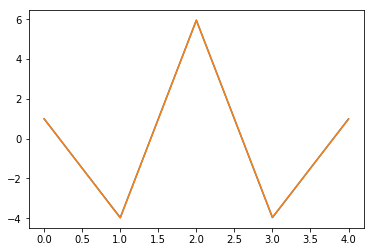

In [83]:
plt.figure();plt.plot(b);plt.plot(a)

# test baseline removal with scipy

In [1]:
1+2

3

In [23]:
m=np.concatenate((np.random.rand(10,5) + 10, np.random.rand(10,5) + 20), axis=1)
m

array([[10.88759368, 10.57937348, 10.33065615, 10.06954275, 10.0515111 ,
        20.74848319, 20.43460505, 20.51966738, 20.71642356, 20.43818105],
       [10.8830593 , 10.83777311, 10.75206654, 10.52725724, 10.34021791,
        20.81357546, 20.66732133, 20.84718956, 20.06766791, 20.13132271],
       [10.08156172, 10.62045678, 10.97578702, 10.68932179, 10.01209144,
        20.62560656, 20.29305681, 20.56789182, 20.79610039, 20.13507661],
       [10.84616995, 10.0032127 , 10.11452173, 10.71285039, 10.47485089,
        20.58968288, 20.32112339, 20.29550348, 20.19206264, 20.37357543],
       [10.10565206, 10.92236577, 10.60233004, 10.09733064, 10.202927  ,
        20.47711687, 20.26360353, 20.85558565, 20.72435135, 20.17374024],
       [10.33437685, 10.37215243, 10.72817638, 10.3560431 , 10.90204626,
        20.71391348, 20.39578016, 20.45062562, 20.54745077, 20.68268608],
       [10.26946214, 10.92654752, 10.41214163, 10.87010779, 10.179475  ,
        20.49009999, 20.71225918, 20.86480053

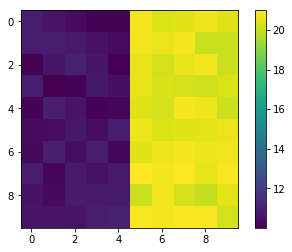

In [24]:
plt.figure()
plt.imshow(m)
plt.colorbar()

In [33]:
md=scipy.signal.detrend(m,axis=1)

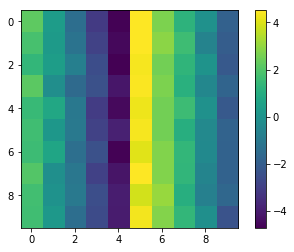

In [34]:
plt.figure()
plt.imshow(md)
plt.colorbar()

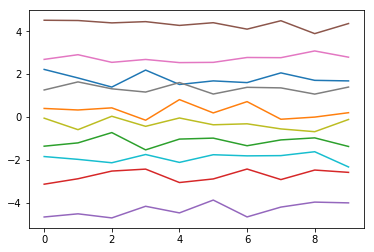

In [37]:
plt.plot(md)

# Now the BANDPASS filter

In [13]:
# real-time data filtering

fs=5000.
f_low = 12.0
f_high = 15.0
butter_ord = 2
lenchannels = 64

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    return b, a

#rt_b, rt_a = signal.butter(butter_ord, [f_low / fn, f_high / fn], btype='band')
b, a = signal.butter(butter_ord, [2*f_low/fs, 2*f_high/fs], btype='band', analog=False)  # a digital high-pass filter
# b, a = butter_bandpass(f_low, f_high, fs, order=1)
zi = proc.lfilter_zi(b, a, lenchannels)


In [3]:
print(b)
print(a)
print(zi)

[ 1.25622484e-11  0.00000000e+00 -5.02489935e-11  0.00000000e+00
  7.53734903e-11  0.00000000e+00 -5.02489935e-11  0.00000000e+00
  1.25622484e-11]
[  1.          -7.9890132   27.9242853  -55.77642513  69.63330857
 -55.63922709  27.78707876  -7.93020433   0.99019711]
[[-8.58388636e-12 -8.58388636e-12 -8.58388636e-12 -8.58388636e-12
  -8.58388636e-12 -8.58388636e-12 -8.58388636e-12 -8.58388636e-12
  -8.58388636e-12 -8.58388636e-12 -8.58388636e-12 -8.58388636e-12
  -8.58388636e-12 -8.58388636e-12 -8.58388636e-12 -8.58388636e-12
  -8.58388636e-12 -8.58388636e-12 -8.58388636e-12 -8.58388636e-12
  -8.58388636e-12 -8.58388636e-12 -8.58388636e-12 -8.58388636e-12
  -8.58388636e-12 -8.58388636e-12 -8.58388636e-12 -8.58388636e-12
  -8.58388636e-12 -8.58388636e-12 -8.58388636e-12 -8.58388636e-12
  -8.58388636e-12 -8.58388636e-12 -8.58388636e-12 -8.58388636e-12
  -8.58388636e-12 -8.58388636e-12 -8.58388636e-12 -8.58388636e-12
  -8.58388636e-12 -8.58388636e-12 -8.58388636e-12 -8.58388636e-12
  -8.5

In [4]:
# load from disk:

with open('c-allm-and-alld.pkl','rb') as f:
    t=pickle.load(f)
for key in t.keys():
    locals()[key] = t[key]

In [5]:
ch_names = ['ch_%d' % i for i in range(64)]

In [6]:
m1=alld[0:20000,:]
m2=alld[20000:40000,:]

In [7]:
cnt1 = io.convert_mushu_data(m1, [], 5000, ch_names)
cnt2 = io.convert_mushu_data(m2, [], 5000, ch_names)

In [8]:
with open('zeroelement.pkl','rb') as f:
    zeroelement = pickle.load(f)

In [9]:
# let's make a '0' data element?


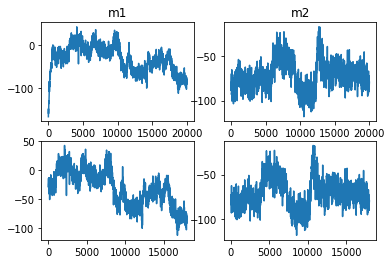

In [10]:
plt.figure()
plt.subplot(221)
plt.plot(cnt1.data[:,10])
plt.title('m1')
plt.subplot(223)
plt.plot(cnt1.data[2000:,10])
plt.subplot(222)
plt.plot(cnt2.data[:,10])
plt.title('m2')
plt.subplot(224)
plt.plot(cnt2.data[2000:,10])


In [11]:
# filter them it with wyrm -- continuous

f_1 = proc.lfilter(cnt1, b, a)
f_0 = proc.lfilter(zeroelement, b, a)
f_2 = proc.lfilter(cnt2, b, a)

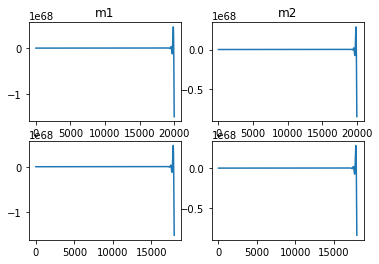

In [12]:
plt.figure()
plt.subplot(221)
plt.plot(f_1.data[:,10])
plt.title('m1')
plt.subplot(223)
plt.plot(f_1.data[2000:,10])
plt.subplot(222)
plt.plot(f_2.data[:,10])
plt.title('m2')
plt.subplot(224)
plt.plot(f_2.data[2000:,10])

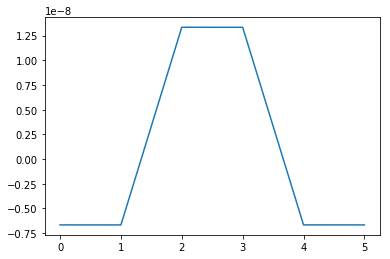

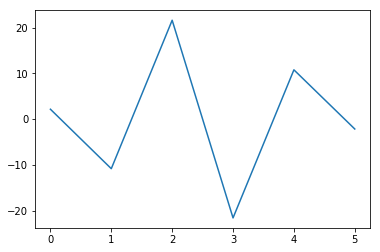

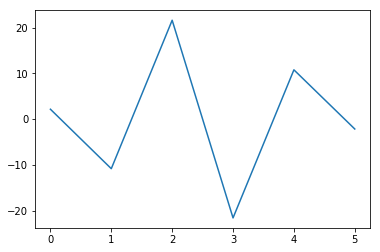

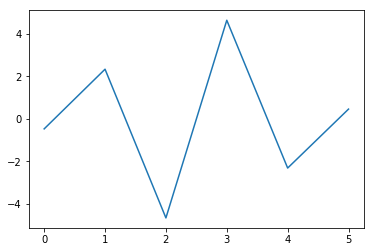

In [28]:
# NOW -- filter it with remembering the state:

zi1=zi
f2_1, zi = proc.lfilter(cnt1, b, a, zi=zi)
zi2=zi
f2_0, zi = proc.lfilter(zeroelement, b, a, zi=zi)
zi3=zi
f2_2, zi = proc.lfilter(cnt2, b, a, zi=zi)
zi4=zi

plt.figure()
plt.plot(zi1[:,1])
plt.figure()
plt.plot(zi2[:,1])
plt.figure()
plt.plot(zi3[:,1])
plt.figure()
plt.plot(zi4[:,1])

# plt.plot(zi3[:,1])

#plt.imshow(zi3)
#plt.colorbar()
#print(zi2)
#print(zi3)

In [29]:
zi4

array([[ 1.78633941e+00, -4.69365870e-01,  1.08225510e+00,
        -7.55998425e-01,  3.25752864e+00, -6.29260760e-02,
         1.88042243e+00,  1.86740557e-01,  1.11024082e+00,
        -2.09165861e-01,  2.31661598e+00, -8.67854337e-01,
         2.46246971e-01, -1.45687931e+00,  1.28310156e+00,
        -1.04498593e+00, -1.08625046e+00,  7.80367436e-01,
         5.09732465e-01, -2.85759745e-01,  1.56504733e+00,
        -3.79124708e-01,  2.15952823e+00,  7.15307688e-01,
         4.03085767e+00, -7.24809735e-01,  2.42922320e+00,
        -6.51575962e-01,  2.42740203e+00, -4.86839250e-01,
         7.51897221e-01,  2.93074481e+01, -6.86243859e-02,
        -1.32123206e+00,  2.55270574e+00,  4.09459841e-01,
         2.08881858e+00,  1.46625790e-01, -3.47968654e-01,
        -1.01156888e+00,  2.99285709e+00, -3.23114030e-01,
         3.07541255e+00,  2.06065347e-01,  8.20852050e-01,
         2.36538319e-02,  1.74550257e+00, -6.56054589e-01,
         4.28202521e+00, -6.49496913e-01,  1.43669552e+0

In [31]:
f2_1.data[10,10]

-0.0016733080715288955

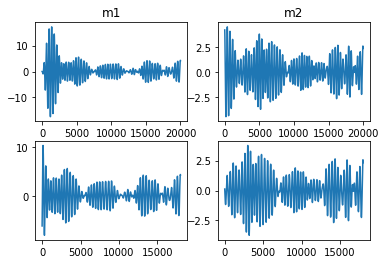

In [30]:
plt.figure()
plt.subplot(221)
plt.plot(f2_1.data[:,10])
plt.title('m1')
plt.subplot(223)
plt.plot(f2_1.data[2000:,10])
plt.subplot(222)
plt.plot(f2_2.data[:,10])
plt.title('m2')
plt.subplot(224)
plt.plot(f2_2.data[2000:,10])

# result:
-- it worked!!
The second picture does NOT anymore show the step-response shown in the earlier figure. Let's cross-check this wit hfilter applied to continuous data

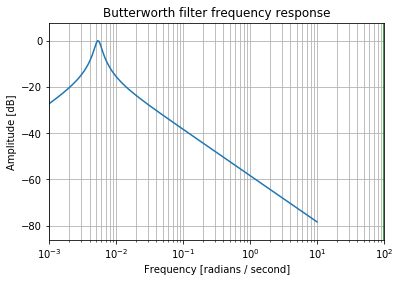

/home/johan/.conda/envs/rt/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/johan/.conda/envs/rt/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10


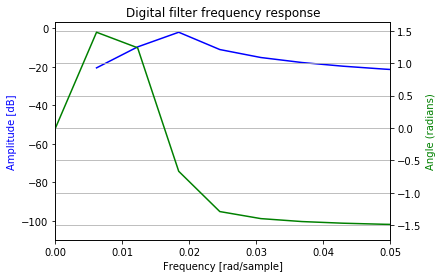

In [30]:
# b, a = signal.butter(4, 2*f_low/fs, btype='high', analog=True)  # a high-pass filter
ORDER=1

b, a = signal.butter(ORDER, [2*f_low/fs, 2*f_high/fs], btype='band', analog=True)  # a digital high-pass filter
w, h = signal.freqs(b, a)


plt.figure()
plt.plot(w, 20 * np.log10(abs(h)))
plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(100, color='green') # cutoff frequency
plt.show()


b, a = signal.butter(ORDER, [2*f_low/fs, 2*f_high/fs], btype='band', analog=False)  # a digital high-pass filter

w, h = signal.freqz(b, a)

fig = plt.figure()
plt.title('Digital filter frequency response')
ax1 = fig.add_subplot(111)


plt.plot(w, 20 * np.log10(abs(h)), 'b')
# plt.xscale('log')

plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')


ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
plt.plot(w, angles, 'g')
plt.ylabel('Angle (radians)', color='g')
plt.grid()
plt.axis('tight')
plt.xlim(0, 0.05)

plt.show()



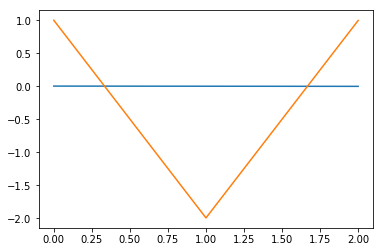

In [31]:
plt.figure();plt.plot(b);plt.plot(a)

In [32]:
b

array([ 0.00188141,  0.        , -0.00188141])

In [33]:
a

array([ 1.        , -1.99595347,  0.99623718])